In [2]:
import os
os.sys.path.append("../")
from scripts.ranking_model_v2 import *

2024-10-17 12:13:58.997791: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-17 12:13:59.367523: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-17 12:13:59.370160: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-17 12:14:05.832642: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.2.2) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
#  Create a Spark Session
spark = (
    SparkSession.builder.appName("Ranking Model")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .config("spark.executor.memory", "4g")
    .getOrCreate()
)

sc = SparkContext.getOrCreate()
sc.setLogLevel("ERROR")

24/10/17 12:14:26 WARN Utils: Your hostname, DESKTOP-H6V94HM resolves to a loopback address: 127.0.1.1; using 192.168.0.220 instead (on interface eth0)
24/10/17 12:14:26 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/17 12:14:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Ranking System

In [4]:
# Reading transactions
transactions = spark.read.parquet(f"../data/curated/transactions.parquet")
transactions = transactions.withColumns(
    {"period": F.date_format(F.col("order_datetime"), "yyyy-MM")})
transactions = transactions.drop("merchant_fp", "consumer_fp")

In [5]:
# Reading predicted fraud probabilities
merchant_fp = spark.read.parquet(f"../data/curated/predicted_merchant_fp.parquet")
consumer_fp = spark.read.parquet(f"../data/curated/predicted_consumer_fp.parquet")

# Join with transaction data
transactions_full = transactions.join(consumer_fp, on = ['consumer_id', 'order_datetime', 'order_id'], how = 'inner')
transactions_full = transactions_full.join(merchant_fp, on = ['merchant_abn', 'order_datetime', 'order_id'], how = 'inner')
# transactions_full.limit(5)

As there are many ways in ranking the top 100 merchants toi join the BNPL firm, we decided adopted the approach of an investor, consider each merchant as a "projects" and evaluating their value. To evluate the merchant's value, we will be using a modified version of **Discounted Cash Flow (DCF)** model where we substitute *cash flow* with *revenue*. The orignal DCF model has the below formula

$$ \text{DCF} = \sum^{n}_{t=1}\frac{CF_t}{(1+r)^t}$$

where $t$ is the time period of cash flow and $r$ is the discount rate.

The DCF model we based on is the one that use **Free Cash Flows (FCF)** from **Earning Before Interest and Tax (EBIT)**. EBIT are usually a percentage of sales revenue and in Corporate Financial Decision Making (FNCE20003), the formula for FCF is defined as

$$ \text{FCF} = \text{EBIT}(1-t) + \text{Depreciation} - \text{Capital Expenditure} - \Delta\text{Working Capital}$$

Since the BNPL charges merchant per transaction, this means that the firm is charging for a percentage of the sales revenue. Thus, the merchant doesn't pay the BNPL firm through EBIT or their FCF. This allows us to safely consider the percentage of revenue of the merchant as cash flows for the BNPL firm.

We will calculate of the project's  DCF using revenues from September 2022, October 2022, and November 2022. The value of the DCF is then multipled by the take rate, which we will called **Expected Project Value (EPV)**. After that, we will assign weights or penalties to the DCF and pick the merchants with the highest DCF.

In [6]:
# Aggregate the data into desried format
agg_transactions = transactions_full.groupBy("merchant_abn", "period", "take_rate").agg(
    F.count(F.col("order_id")).alias("num_orders"),
    F.round(F.sum("dollar_value"),2).alias('revenue'),
    F.round(F.mean(F.col("dollar_value")), 2).alias("revenue_per_order"),
    F.round(F.mean(F.col("merchant_fp")), 2).alias("avg_merchant_fp"),
    F.round(F.mean(F.col("consumer_fp")), 2).alias("avg_consumer_fp")
)

agg_transactions = agg_transactions.orderBy(["merchant_abn", "period"], ascending = [False, True])

# Partition the data based on merchant ABN and comput lag variables for each specific partition
merchant_partition = Window.partitionBy("merchant_abn").orderBy("period")
agg_transactions = agg_transactions.withColumns({
    "revenue_lag_1": F.lag("revenue", 1, None).over(merchant_partition),
    "revenue_lag_2": F.lag("revenue", 2, None).over(merchant_partition),
    "revenue_lag_3": F.lag("revenue", 3, None).over(merchant_partition),
    "num_order_lag_1": F.lag("num_orders", 1, None).over(merchant_partition),
    "num_order_lag_2": F.lag("num_orders", 2, None).over(merchant_partition),
    "expected_profit": F.round(F.col("revenue") * F.col("take_rate")/100,2)
    })
agg_transactions = agg_transactions.withColumns({
    "revenue_growth":
        F.when(F.col("revenue_lag_1").isNotNull(), F.round((F.col("revenue") - F.col("revenue_lag_1"))/F.col("revenue_lag_1"), 2)).otherwise(None),
    "revenue_growth_lag_1": F.when(F.col("revenue_lag_2").isNotNull(), 
        F.round((F.col("revenue_lag_1") - F.col("revenue_lag_2"))/F.col("revenue_lag_2"), 2)).otherwise(None),
    "revenue_growth_lag_2": F.when(F.col("revenue_lag_3").isNotNull(), 
        F.round((F.col("revenue_lag_2") - F.col("revenue_lag_3"))/F.col("revenue_lag_3"), 2)).otherwise(None)})

Comparing different merchants' values using the DCF model is only reliable when all merchants have revenue in the timeline of interest i.e from May 2021 to August 2022, all merchants must have sales in each month. We noticed that there are some merchants with no revenue in some particular month. Thus, we decide to asume that the missing revenue in some moths of some merchants are totally due to the merchant's inability to make any sales and not because of data entry errors. We adopted the perspective that we want merchants that have consistent sales. We will only consider merchants with 15 months of revenue records, prior to the date of the last transaction entry.

In [7]:
# Create a dataframe that store the valid date range of the data
months = pd.date_range(start="2021-06-01", end="2022-08-31", freq='MS').strftime('%Y-%m').tolist()
months_df = spark.createDataFrame([(month,) for month in months], ["period"])

# Join with the transactions dataframe
transactions_correct_months = transactions.join(months_df, on= ['period'], how = 'right')

# Get the list of merchants with complete sales records
complete_merchants = transactions_correct_months.groupBy("merchant_abn").agg(F.countDistinct("period")\
                                                                             .alias("month_count")).filter(F.col("month_count") == len(months)).select("merchant_abn")
print(f"Number of merchants with complete sales records: {complete_merchants.count()}")

Number of merchants with complete sales records: 3212


In [8]:
# # Select the merchants with complete sales records from the aggregated sales 
# print(f"Number of entries before removing merchants with missing sales records: {agg_transactions.count()}")
# agg_transactions = agg_transactions.join(complete_merchants, on='merchant_abn', how='inner')
# agg_transactions = agg_transactions.filter("2021-06" <= F.col("period")).orderBy(['merchant_abn', 'period'],
#                                                                                       ascending = [True, True])
# print(f"Number of entries after removing merchants with missing sales records: {agg_transactions.count()}")

# # Export the aggregated transactions to reduce the need to run this block again
# agg_transactions.write.parquet(f"../data/curated/agg_transactions.parquet", mode = 'overwrite')

In [9]:
agg_transactions = spark.read.parquet(f"../data/curated/agg_transactions.parquet")

In [10]:
agg_transactions_sub = agg_transactions.select(*['merchant_abn', 'period', 'revenue', 'revenue_lag_1', 'revenue_lag_2', 'revenue_lag_3',
'revenue_growth_lag_1', 'revenue_growth_lag_2'])


Since the last month of sales record is August 2022, this means that we have to forecast the revenues of the next 3 months. We will try 2 different approaches for forecasting revenue of 3 periods into the future. The first approach is to use a simple LSTM to predict the revenue. Contrast to the machine learning nature of approach 1, the second approach will be simply to compute the average monthly revenue growth rate of the 15 months period and then assume that revenues after August 2022 will grow by the same amount.

In [11]:
# for merchant in complete_merchants.rdd.flatMap(lambda x:x).collect():
#     # Predict sales revenue 3 period for all valid merchants
#     partition = agg_transactions_sub.filter(F.col("merchant_abn") == merchant)
    
#     forecasted_revenue = forecast_revenue(partition)

#     print(forecasted_revenue)
#     break

If we run the above code multiple times, we will see that the forecasted revenues will change with each rerun. This is because the weights between the units are randomly intialise each time and Stochastic Gradient Descent isn't guaranteed to always find the local maximum and minimum. Thus, in order to train a neural network that minimise the mean squared error, we would have to fine-tune our model. The process would be feasible if we're doing for 8-10 merchants. However, our data contains more than 3000 merchants which would be computationally expensive. Thus, we will stick with the second approach that was mentioned previously.

Let's aggregate our data and find the monthly average growth for each merchant. From there, we can compute the DCF for each of them

In [12]:
agg_transactions.limit(1)

merchant_abn,period,take_rate,num_orders,revenue,revenue_per_order,avg_merchant_fp,avg_consumer_fp,revenue_lag_1,revenue_lag_2,revenue_lag_3,num_order_lag_1,num_order_lag_2,expected_profit,revenue_growth,revenue_growth_lag_1,revenue_growth_lag_2
63937753588,2021-10,4.17,14,42480.29,3034.31,41.25,16.06,20691.97,41997.37,36180.46,8,12,1771.43,1.05,-0.51,0.16


In [13]:
merchant_avg_growth = agg_transactions.groupBy("merchant_abn", ).agg(
    F.mean(F.col('revenue_growth')).alias('avg_monthly_revenue_growth'),
    F.mean(F.col("num_orders")).alias("avg_num_orders"),
    F.mean(F.col("revenue_per_order")).alias('avg_revenue_per_order'),
    (F.stddev(F.col('revenue'))/F.mean(F.col('revenue'))).alias("coef_of_variation"),
    F.stddev(F.col('revenue_growth')).alias("std_reveune_growth")
)
merchant_latest_revenue = agg_transactions.filter(F.col("period") == '2022-08').select("merchant_abn", "revenue", "take_rate")
merchant_latest_revenue = merchant_latest_revenue.join(merchant_avg_growth, on ='merchant_abn', how = 'inner')
merchant_latest_revenue = merchant_latest_revenue.withColumns({
    "forecasted_revenue_1": F.col("revenue") * (1 + F.col("avg_monthly_revenue_growth")),
    "forecasted_revenue_2": F.col("revenue") * (1 + F.col("avg_monthly_revenue_growth"))**2,
    "forecasted_revenue_3": F.col("revenue") * (1 + F.col("avg_monthly_revenue_growth"))**3,
})

According to the Victoria State Government [website](https://djsir.vic.gov.au/about-us/overview/the-economic-assessment-information-portal/i-am-looking-for-guidance-on-particular-economic-assessment-processes,-methods-and-variables#:~:text=Department%20of%20Treasury%20and%20Finance,on%20the%20category%20of%20investment.), there is no single discount rate. As a general guideline, the discount rate is between 4% and 7%. We acknowledge that each merchant may have their own discount rates but it's quite extensive to give each and everyone of them an individual discount rate. Thus, we will use the mid point of the recommended range and apply it to all merchants.

In [14]:
discount_rate = 1.055

merchant_latest_revenue = merchant_latest_revenue.withColumns(
    {"discounted_revenue_flow": F.col("forecasted_revenue_1")/discount_rate + F.col("forecasted_revenue_2")/discount_rate**2 + F.col("forecasted_revenue_3")/discount_rate**3,
     "expected_project_value": F.col("discounted_revenue_flow") * F.col('take_rate')/100}
    )
merchant_latest_revenue = merchant_latest_revenue.drop("forecasted_revenue_1", "forecasted_revenue_2", "forecasted_revenue_3", "revenue", "take_rate")
merchant_latest_revenue

merchant_abn,avg_monthly_revenue_growth,avg_num_orders,avg_revenue_per_order,coef_of_variation,std_reveune_growth,discounted_revenue_flow,expected_project_value
73256306726,0.02066666666666667,269.1333333333333,284.46199999999993,0.20053707832195655,0.23998412645919096,191447.79571678603,9208.638973977408
73841664453,0.06533333333333333,47.13333333333333,86.75933333333334,0.2788256236984031,0.26699027983020196,15736.800264718144,873.392414691857
78916025936,3.8819999999999992,3.8,321.5033333333332,0.7532806819543889,12.823639554688496,291776.5269985978,1079.5731498948119
83412691377,0.025333333333333333,727.1333333333333,34.932,0.16312759228803875,0.17307581603227556,77261.59325069639,2271.490841570474
92202115241,0.09266666666666667,5.8,333.6026666666666,0.41587657752670437,0.6025833275711059,4417.673386814076,250.04031369367672
96946925998,0.34,6.0,924.2446666666666,0.6041988901065665,1.3132565846561963,27450.551701676337,1644.2880469304125
64185141673,1.1159999999999999,5.2,290.19066666666663,0.6354321269447655,2.478818266836034,15163.199259590589,874.9165972783769
66610548417,0.092,10.8,936.6219999999998,0.2972128564236676,0.41068235900754246,39351.835035257325,2585.4155618164064
71002398501,0.33999999999999997,6.466666666666667,326.126,0.4544716307485942,1.372630425757161,7819.599611378878,295.58086531012157
72762528640,0.25133333333333335,3.6666666666666665,273.3106666666667,0.5389553454598275,0.9667387493650027,1296.750849223466,29.176894107527986


We will also be using the predicted fraud probability for both merchants and consumer as part of our ranking system. We will assign our weights of choice, $\alpha$ and $\beta$ to the merchants and consumers' fraud probability, respectively, and sum them. We think that the merchant's fraud probability is more important to the BNPL firm as a merchant with a higher fraud probability with likely to commit scams, thus damaging the BNPL firm's reputation and customer will not shop from the firm anymore. Whereas for customer, it's easier to assess the risk of a customer not paying for the items. Thus, we decided the weight is going to be $\alpha = 0.65$ and $\beta = 0.35$. The formula for the combined fraud probability is:

$$\text{Combined Fraud Probability (CBF)} = \alpha \times \text{Merchant's FP} + \beta\times\text{Consumer's FP}$$

We will use the combined fraud probability to get the fraud-adjusted DCF

$$ \text{Fraud-adjusted EPV} = (1 - \text{CBF}) \times \text{EPV}

In [15]:
avg_fp = agg_transactions.withColumns({
    "total_merchant_fp": F.col("avg_merchant_fp") * F.col("num_orders"),
    "total_consumer_fp": F.col("avg_consumer_fp") * F.col("num_orders"),
}).select("merchant_abn", "period", "num_orders", "total_merchant_fp", "total_consumer_fp")

avg_fp = avg_fp.groupBy("merchant_abn").agg(
    (F.sum(F.col("total_merchant_fp"))/F.sum(F.col("num_orders"))).alias("avg_merchant_fp"),
    (F.sum(F.col("total_consumer_fp"))/F.sum(F.col("num_orders"))).alias("avg_consumer_fp")
)

In [16]:
alpha = 0.65
beta = 0.35

avg_fp = avg_fp.withColumn("combined_fp", alpha * F.col("avg_merchant_fp") + beta * F.col('avg_consumer_fp'))
merchant_ranking_metrics = merchant_latest_revenue.join(avg_fp, on='merchant_abn', how='inner')
merchant_ranking_metrics = merchant_ranking_metrics.drop("avg_merchant_fp","avg_consumer_fp")

In [17]:
merchant_ranking_metrics = merchant_ranking_metrics.withColumn(
    "risk_adjusted_epv",
    F.col("expected_project_value") * (1 - F.col("combined_fp")/100)
)

In [18]:
merchant_ranking_metrics.orderBy("std_reveune_growth", ascending = False).limit(10)

merchant_abn,avg_monthly_revenue_growth,avg_num_orders,avg_revenue_per_order,coef_of_variation,std_reveune_growth,discounted_revenue_flow,expected_project_value,combined_fp,risk_adjusted_epv
70344541271,51.08466666666667,4.866666666666666,1081.5886666666665,0.5737462225685777,195.37035923989032,7.229664594670486E8,4.128138483556847E7,42.42405479452055,2.3768147512990005E7
71616292306,27.928666666666665,2.6666666666666665,210.442,0.730322688378949,106.90505098762485,5417787.616379169,177161.6550555988,39.5622125,107072.58461398579
95276443363,15.658666666666665,3.6,296.6186666666666,0.6820969976318357,51.655349033856346,6601250.027970397,251507.6260656721,39.01125925925927,153391.33400438444
75547072158,12.812666666666667,3.8666666666666667,284.17533333333336,0.7476836101265073,48.9629811281174,253224.4641329908,11445.745778811182,39.041500000000006,6977.154940576614
12171241826,10.885333333333334,8.2,228.37266666666665,0.568344026863831,40.80740511697543,5073911.329712124,209552.5379171107,38.0224756097561,129875.47529795238
33223110337,10.853333333333333,2.8,214.40200000000002,0.9092808051054941,38.67401336199554,463179.7602395222,21908.402659329404,38.604011904761904,13450.880288578708
70783350473,10.031333333333333,3.066666666666667,576.6173333333334,0.5781118668358438,36.41120272401783,2314209.098268511,42812.86831796745,38.95503260869566,26135.101503985294
52129470223,9.220000000000002,4.866666666666666,309.45399999999995,0.6017263523053834,33.47001707285407,3312653.5794925285,109317.56812325344,39.02289726027398,66658.68582708623
33790986203,7.944,5.2,327.7420000000001,0.6609718021645656,27.62230615178351,2327647.7691004816,140589.9252536691,41.86257051282051,81735.3686604302
51420872378,8.786666666666665,2.8,258.158,0.9624601796783046,23.669936829738464,30096.247715517915,990.1665498405393,38.90971428571428,604.8955743448707


From the table above, we can see that the merchant 1 has a risk-adjusted EPV of approximately $23 millions. This is due to their average monthly revenue growth rate is 5108% which is a massive growth. This is due to fact that this merchant has highly fluctuating monthly revenue growth rate which may affect the average monthly growth rate. Thus, it's important that we penalised merchant with high revenue growth standard deviation. We will use a modified Winsorizor method to remove any standard deviation of revenue growth that are outliers.

This is the intial approach for removing  merchant with unstable revenue growth rate. Double click the cell to view
<!-- The formula for calculating the weight is

$$W_{\text{Revenue growth}} = \frac{1}{\log (1+s^{\text{r.g}}_i)} - \frac{1}{2}$$

where $s^{\text{rev growth}}_i$ is the standard deviation of the merchant's revenue growth rate accross the 15 months period. -->

In [19]:
lower_bound = merchant_ranking_metrics.select(F.percentile(F.col("std_reveune_growth"), 0.01)).first()[0]
upper_bound = merchant_ranking_metrics.select(F.percentile(F.col("std_reveune_growth"), 0.99)).first()[0]

merchant_ranking_metrics = merchant_ranking_metrics.filter((lower_bound <= F.col("std_reveune_growth")) & (F.col("std_reveune_growth") <= upper_bound))

<Figure size 432x288 with 0 Axes>

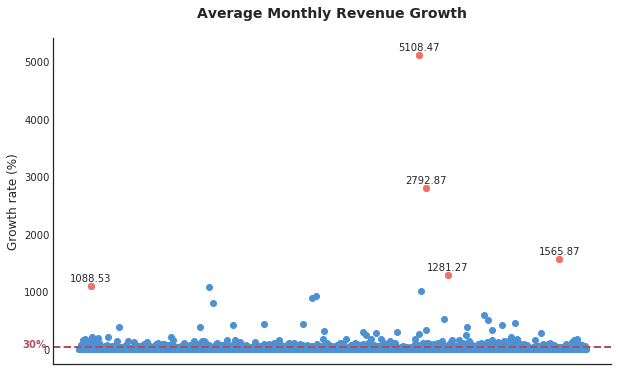

In [20]:
growth_df = merchant_latest_revenue.select("merchant_abn", "avg_monthly_revenue_growth").toPandas()

# Scatter plot: Merchants vs Growth Rate
df_sorted = growth_df.sort_values(by='avg_monthly_revenue_growth', ascending=False)
top_5 = df_sorted.head(5)

plt.style.use('seaborn-white')
plt.figure(facecolor='#FDFDFD')
plt.figure(figsize=(10, 6))

plt.scatter(growth_df['merchant_abn'], growth_df['avg_monthly_revenue_growth'] * 100, color='#4C91D4', label='All Merchants') # Plot all merchants
plt.scatter(top_5['merchant_abn'], top_5['avg_monthly_revenue_growth']* 100, color='#FF6F61', label='Top 5 Merchants') # Highlight the top 5 merchants with red color
plt.axhline(30, color='#AD505E', linestyle='dashed', linewidth=2)
plt.text(10, 30, "30%", color='#AD505E',  fontweight= 'bold')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

for i, row in top_5.iterrows():
    plt.annotate(f"{round(row['avg_monthly_revenue_growth'] *100,2)}", (row['merchant_abn'], row['avg_monthly_revenue_growth']*100), textcoords="offset points", xytext=(0,5), ha='center')

# Add labels and title
plt.xticks([])
plt.title("Average Monthly Revenue Growth", fontweight = 'bold', fontsize=14, pad=20)
plt.ylabel("Growth rate (%)", fontsize = 12)
# plt.savefig(f"../plots/growth_rate", transparent = True)
plt.savefig(f"../plots/growth_rate_v2", transparent = False)

In [21]:
merchant_ranking_metrics.orderBy("risk_adjusted_epv", ascending = False).limit(10)

merchant_abn,avg_monthly_revenue_growth,avg_num_orders,avg_revenue_per_order,coef_of_variation,std_reveune_growth,discounted_revenue_flow,expected_project_value,combined_fp,risk_adjusted_epv
97884414539,1.6406666666666667,3.0,9981.536666666665,0.7347099651497621,4.043104300033871,1895396.73499406,129266.05732659489,44.049511111111116,72324.99104162121
48534649627,0.025333333333333336,3335.4666666666667,143.09733333333332,0.17851904439502903,0.1612392484418581,1400750.4061942906,93009.82697130089,30.673439088983052,64480.51434849038
86578477987,0.026000000000000002,13805.266666666666,35.028,0.17180320536602955,0.1635236985883086,1426866.798267028,91747.5351285699,30.291424461195973,63955.89983008991
32361057556,0.025333333333333333,4341.933333333333,109.82733333333334,0.1775619949607971,0.17058163804494092,1380419.1374607098,91245.70498615292,30.4234067389335,63485.65302640829
45629217853,0.027333333333333334,11255.333333333334,37.83866666666667,0.18717135892602974,0.17826411651842677,1265784.8255556792,88351.78082378641,30.81994237694723,61121.81288488873
79827781481,0.028666666666666667,241.2,2036.1873333333338,0.1758887478875903,0.18814381530652352,1417110.0615200887,96646.90619567005,38.2490462962963,59680.386300950144
21439773999,0.024666666666666667,6118.266666666666,78.28,0.17513345558089158,0.16422400497346243,1387461.9684095625,84635.1800729833,30.246255208446836,59036.20751198023
96680767841,0.029333333333333333,1582.3333333333333,315.58133333333336,0.1762583893366516,0.18997994881666053,1468326.4819790302,86778.09508496069,32.35259734569201,58703.12739786161
38700038932,0.02266666666666666,365.26666666666665,1337.1320000000003,0.17855375493793263,0.17878425412717286,1418536.365320908,89509.64465174929,34.81062803431283,58350.77519719366
64403598239,0.025333333333333333,5752.2,78.12666666666668,0.17188020953378486,0.1548209411207793,1323501.879621348,83512.96860410707,30.271728173568377,58232.14975859427


There are also some merchant with a very few amount of orders per month. From the BNPL perspective, we would want merchants with a decent amount of order volume per month as more volume would likely result in more revenue for BNPL firm. We also found that a low average monthly order volume also lead to unstable growth rate, thus, led to unrealistic forecasted revenues. Thus, we need to create a weight that penalises merchant with low order volume. The weight is compute using a Sigmoid function

$$ W_{\text{num orders}} = \frac{1}{1 + e^{-(\bar{x_i} - \bar{x_{.}})}}$$

where $\bar{x_i}$ is the average number of order of merchant $i$ and $\bar{x_.}$ is the average number of order of all merchants.

<Figure size 432x288 with 0 Axes>

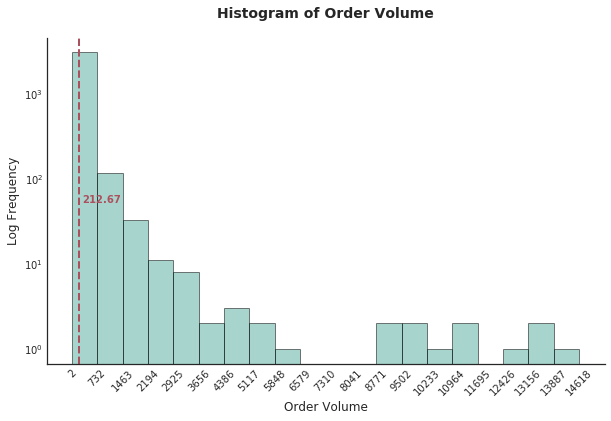

In [22]:
avg_order_vol = merchant_latest_revenue.select("merchant_abn", "avg_num_orders").toPandas()

log_mean_order_volume = np.log(np.mean(avg_order_vol['avg_num_orders']))
plt.figure(facecolor='#FDFDFD')
plt.figure(figsize=(10, 6))
plt.axvline(np.exp(log_mean_order_volume), color='#AD505E', linestyle='dashed', linewidth=2)
_, bins, _ = plt.hist(avg_order_vol['avg_num_orders'], bins=20, color="#50AD9F", edgecolor="black", log=True, alpha=0.5)
plt.text(np.exp(log_mean_order_volume + 1.4) , 50, f'{np.exp(log_mean_order_volume):.2f}', color='#AD505E',  fontweight= 'bold',
         horizontalalignment='center', verticalalignment='bottom')
plt.xticks(bins, rotation=45)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# plt.savefig(f"../plots/order_volume", transparent = True)
plt.title("Histogram of Order Volume", fontweight='bold', size=14, pad=20)
plt.ylabel("Log Frequency", fontsize = 12)
plt.xlabel("Order Volume", fontsize=12)
plt.savefig(f"../plots/order_volume_v2", transparent = False)

In [23]:
np.mean(avg_order_vol['avg_num_orders'])

212.6747613117476

In [24]:
log_mean_order_volume

5.359764056546743

In [25]:
# Compute average monthly order volume of all merchants
mean_num_orders = agg_transactions.agg(F.mean("num_orders")).collect()[0][0]
mean_num_orders

212.6747613117476

In [26]:
merchant_ranking_metrics = merchant_ranking_metrics.withColumn("risk_adjusted_epv", F.col("risk_adjusted_epv") * (1/(1 + F.exp(-F.col("avg_num_orders"))*np.exp(mean_num_orders))))
merchant_ranking_metrics.orderBy("risk_adjusted_epv", ascending = False).limit(10)

merchant_abn,avg_monthly_revenue_growth,avg_num_orders,avg_revenue_per_order,coef_of_variation,std_reveune_growth,discounted_revenue_flow,expected_project_value,combined_fp,risk_adjusted_epv
48534649627,0.025333333333333336,3335.4666666666667,143.09733333333332,0.17851904439502903,0.1612392484418581,1400750.4061942906,93009.82697130089,30.673439088983052,64480.51434849038
86578477987,0.026000000000000002,13805.266666666666,35.028,0.17180320536602955,0.1635236985883086,1426866.798267028,91747.5351285699,30.291424461195973,63955.89983008991
32361057556,0.025333333333333333,4341.933333333333,109.82733333333334,0.1775619949607971,0.17058163804494092,1380419.1374607098,91245.70498615292,30.4234067389335,63485.65302640829
45629217853,0.027333333333333334,11255.333333333334,37.83866666666667,0.18717135892602974,0.17826411651842677,1265784.8255556792,88351.78082378641,30.81994237694723,61121.81288488873
79827781481,0.028666666666666667,241.2,2036.1873333333338,0.1758887478875903,0.18814381530652352,1417110.0615200887,96646.90619567005,38.2490462962963,59680.38630092573
21439773999,0.024666666666666667,6118.266666666666,78.28,0.17513345558089158,0.16422400497346243,1387461.9684095625,84635.1800729833,30.246255208446836,59036.20751198023
96680767841,0.029333333333333333,1582.3333333333333,315.58133333333336,0.1762583893366516,0.18997994881666053,1468326.4819790302,86778.09508496069,32.35259734569201,58703.12739786161
38700038932,0.02266666666666666,365.26666666666665,1337.1320000000003,0.17855375493793263,0.17878425412717286,1418536.365320908,89509.64465174929,34.81062803431283,58350.77519719366
64403598239,0.025333333333333333,5752.2,78.12666666666668,0.17188020953378486,0.1548209411207793,1323501.879621348,83512.96860410707,30.271728173568377,58232.14975859427
89726005175,0.026,10937.533333333333,41.28066666666666,0.17785400363988527,0.1696551123392901,1346359.9274887978,80916.23164207675,30.303525237256423,56395.76096538315


The **coefficient of variation** is a ratio between the standard deviation and the mean, measuring the relative stability which help us compare merchants with different average revenue. Thus, we will create a weight that favors merchant with higher stability. The weight is calculate as

$$W_{\text{CV}} = \frac{1}{1 + CV}$$

In [27]:
merchant_ranking_metrics = merchant_ranking_metrics.withColumn("risk_adjusted_epv", F.col("risk_adjusted_epv") * (1/(1 + F.col("coef_of_variation") )))
merchant_ranking_metrics.orderBy("risk_adjusted_epv", ascending = False).limit(10)

merchant_abn,avg_monthly_revenue_growth,avg_num_orders,avg_revenue_per_order,coef_of_variation,std_reveune_growth,discounted_revenue_flow,expected_project_value,combined_fp,risk_adjusted_epv
48534649627,0.025333333333333336,3335.4666666666667,143.09733333333332,0.17851904439502903,0.1612392484418581,1400750.4061942906,93009.82697130089,30.673439088983052,54713.17129337545
86578477987,0.026000000000000002,13805.266666666666,35.028,0.17180320536602955,0.1635236985883086,1426866.798267028,91747.5351285699,30.291424461195973,54579.04496012397
32361057556,0.025333333333333333,4341.933333333333,109.82733333333334,0.1775619949607971,0.17058163804494092,1380419.1374607098,91245.70498615292,30.4234067389335,53912.79040771167
45629217853,0.027333333333333334,11255.333333333334,37.83866666666667,0.18717135892602974,0.17826411651842677,1265784.8255556792,88351.78082378641,30.81994237694723,51485.24888621164
79827781481,0.028666666666666667,241.2,2036.1873333333338,0.1758887478875903,0.18814381530652352,1417110.0615200887,96646.90619567005,38.2490462962963,50753.42918974075
21439773999,0.024666666666666667,6118.266666666666,78.28,0.17513345558089158,0.16422400497346243,1387461.9684095625,84635.1800729833,30.246255208446836,50237.87488272766
96680767841,0.029333333333333333,1582.3333333333333,315.58133333333336,0.1762583893366516,0.18997994881666053,1468326.4819790302,86778.09508496069,32.35259734569201,49906.659905709246
64403598239,0.025333333333333333,5752.2,78.12666666666668,0.17188020953378486,0.1548209411207793,1323501.879621348,83512.96860410707,30.271728173568377,49691.21355992612
38700038932,0.02266666666666666,365.26666666666665,1337.1320000000003,0.17855375493793263,0.17878425412717286,1418536.365320908,89509.64465174929,34.81062803431283,49510.49110209373
89726005175,0.026,10937.533333333333,41.28066666666666,0.17785400363988527,0.1696551123392901,1346359.9274887978,80916.23164207675,30.303525237256423,47880.09446935283


Now that we have found the adjusted EPV that accounts for different factor, we can now merge the merchants to their respective segments and will select top 20 merchants from each segnment.

In [28]:
# Reading in the segmented merchants
segments = spark.read.parquet(f"../data/curated/segmented_merchants_info.parquet/")
segments = segments.select("name", "merchant_abn", "segments")

complete_ranking = merchant_ranking_metrics.select("merchant_abn", "risk_adjusted_epv")

# Merge ranking with segments
complete_ranking = complete_ranking.join(segments, on = 'merchant_abn', how='inner')
complete_ranking.show(10, truncate = False)

+------------+----------------------+--------------------------------------+-------------------------------------------------+
|merchant_abn|risk_adjusted_epv     |name                                  |segments                                         |
+------------+----------------------+--------------------------------------+-------------------------------------------------+
|73256306726 |5106.3445582384       |Id LLP                                |Fashion, Personal Accessories, Health, and Beauty|
|73841664453 |5.079036435468569E-70 |Lacinia At LLP                        |Books, Media, Arts, Crafts, and Hobbies          |
|83412691377 |1405.0444371658846    |Suspendisse Sagittis Nullam Associates|Fashion, Personal Accessories, Health, and Beauty|
|92202115241 |1.4102977797408417E-88|Fames Ac Turpis Limited               |Books, Media, Arts, Crafts, and Hobbies          |
|96946925998 |1.0739640028656378E-87|Nisi Cum Corporation                  |Books, Media, Arts, Crafts, and Hob

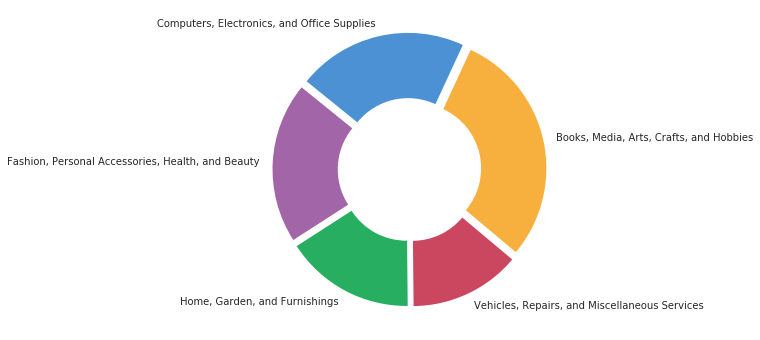

In [29]:
grouped_segments = complete_ranking.groupBy("segments").agg(F.count("merchant_abn").alias('num_merchants')).orderBy("num_merchants", ascending = False)
grouped_segments_pd = grouped_segments.toPandas()
colours = ["#f7b03e", "#4c91d4", "#a265a8", "#27ae60" ,"#cb4760"]

plt.figure(figsize=(10,6))
plt.pie(grouped_segments_pd['num_merchants'], colors=colours, wedgeprops=dict(width=0.5), startangle=-40, explode= [0.05]*5, labels=grouped_segments_pd['segments'])
plt.savefig(f"../plots/donut_chart_segments", transparent=True)
plt.show()

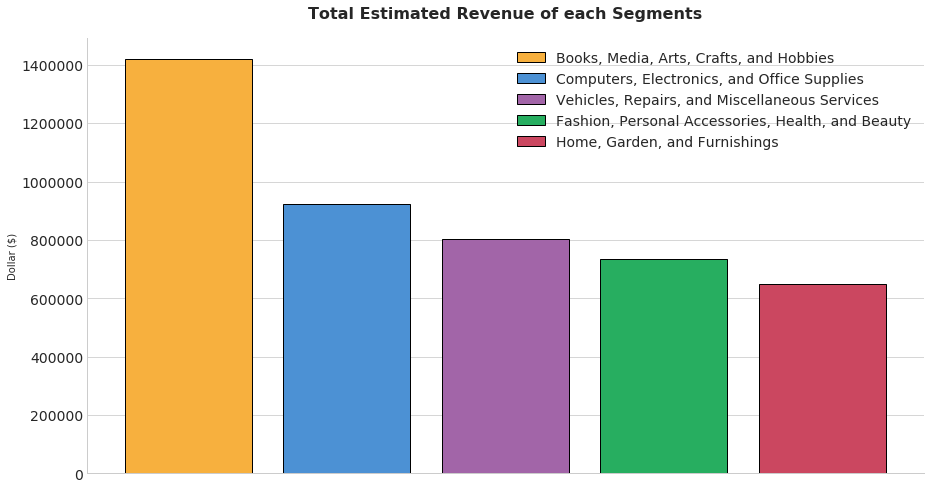

In [46]:
total_value_segments = complete_ranking.groupBy("segments").agg(F.sum("risk_adjusted_epv").alias("total_epv")).orderBy("total_epv", ascending=False)
total_value_segments_pd = total_value_segments.toPandas()

plt.figure(figsize=(15,8))
plt.style.use('seaborn-whitegrid')
bars= plt.bar(total_value_segments_pd['segments'], total_value_segments_pd['total_epv'], color = colours, edgecolor = 'black')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.yticks(size=14)
plt.xticks([])
plt.legend(bars, total_value_segments_pd['segments'], fontsize=14)
plt.title("Total Estimated Revenue of each Segments", fontsize=16, fontweight='bold',
          pad=20)
plt.ylabel("Dollar ($)")
# plt.savefig(f'../plots/total_revenue_segments', transparent = True)
plt.savefig(f'../plots/total_revenue_segments_v2', transparent = False)
plt.show()

In [142]:
total_value_segments_pd

,segments,total_epv
0,"Books, Media, Arts, Crafts, and Hobbies",1.419670e+06
1,"Computers, Electronics, and Office Supplies",9.237914e+05
2,"Vehicles, Repairs, and Miscellaneous Services",8.031290e+05
3,"Fashion, Personal Accessories, Health, and Beauty",7.351826e+05
4,"Home, Garden, and Furnishings",6.485205e+05


24/10/07 21:13:09 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

In [86]:
segments = ["Computers, Electronics, and Office Supplies", "Home, Garden, and Furnishings", "Books, Media, Arts, Crafts, and Hobbies", "Fashion, Personal Accessories, Health, and Beauty"
            , "Vehicles, Repairs, and Miscellaneous Services"]

In [87]:
seg1_ranking = complete_ranking.filter(F.col('segments') == segments[0])
seg1_ranking = seg1_ranking.orderBy("risk_adjusted_epv", ascending=False)
seg1_ranking.write.parquet(f"../data/curated/seg1_ranking.parquet", mode='overwrite')
seg1_ranking.show(10, truncate = False)

+------------+------------------+-----------------------------+-------------------------------------------+
|merchant_abn|risk_adjusted_epv |name                         |segments                                   |
+------------+------------------+-----------------------------+-------------------------------------------+
|21439773999 |50237.87488272766 |Mauris Non Institute         |Computers, Electronics, and Office Supplies|
|82368304209 |47340.66112303206 |Nec Incorporated             |Computers, Electronics, and Office Supplies|
|35909341340 |40682.22831221837 |Arcu Sed Eu Incorporated     |Computers, Electronics, and Office Supplies|
|45433476494 |36275.68139853707 |Adipiscing Elit Foundation   |Computers, Electronics, and Office Supplies|
|58454491168 |35154.509483312075|Diam At Foundation           |Computers, Electronics, and Office Supplies|
|94690988633 |34267.85544270964 |Eu Placerat LLC              |Computers, Electronics, and Office Supplies|
|67400260923 |28740.14389522

In [88]:
seg2_ranking = complete_ranking.filter(F.col('segments') == segments[1])
seg2_ranking = seg2_ranking.orderBy("risk_adjusted_epv", ascending=False)
seg2_ranking.write.parquet(f"../data/curated/seg2_ranking.parquet", mode='overwrite')
seg2_ranking.show(10, truncate = False)

+------------+------------------+------------------------------+-----------------------------+
|merchant_abn|risk_adjusted_epv |name                          |segments                     |
+------------+------------------+------------------------------+-----------------------------+
|79827781481 |50753.42918974075 |Amet Risus Inc.               |Home, Garden, and Furnishings|
|76767266140 |39744.37216363429 |Phasellus At Limited          |Home, Garden, and Furnishings|
|43186523025 |37023.390424610785|Lorem Ipsum Sodales Industries|Home, Garden, and Furnishings|
|49212265466 |32280.258727887383|Auctor Company                |Home, Garden, and Furnishings|
|21772962346 |29226.73924604561 |Purus Gravida Sagittis Ltd    |Home, Garden, and Furnishings|
|38090089066 |26982.619960897013|Interdum Feugiat Sed Inc.     |Home, Garden, and Furnishings|
|42355028515 |26876.88514332147 |Eu Inc.                       |Home, Garden, and Furnishings|
|76314317957 |26000.036184292283|Semper Corp.     

In [89]:
seg3_ranking = complete_ranking.filter(F.col('segments') == segments[2])
seg3_ranking = seg3_ranking.orderBy("risk_adjusted_epv", ascending=False)
seg3_ranking.write.parquet(f"../data/curated/seg3_ranking.parquet", mode='overwrite')
seg3_ranking.show(10, truncate = False)

+------------+------------------+-----------------------------+---------------------------------------+
|merchant_abn|risk_adjusted_epv |name                         |segments                               |
+------------+------------------+-----------------------------+---------------------------------------+
|32361057556 |53912.79040771167 |Orci In Consequat Corporation|Books, Media, Arts, Crafts, and Hobbies|
|45629217853 |51485.24888621164 |Lacus Consulting             |Books, Media, Arts, Crafts, and Hobbies|
|64403598239 |49691.21355992612 |Lobortis Ultrices Company    |Books, Media, Arts, Crafts, and Hobbies|
|94493496784 |44891.043232800184|Dictum Phasellus In Institute|Books, Media, Arts, Crafts, and Hobbies|
|63123845164 |44701.43692027049 |Odio Phasellus Institute     |Books, Media, Arts, Crafts, and Hobbies|
|72472909171 |40469.11957641558 |Nullam Consulting            |Books, Media, Arts, Crafts, and Hobbies|
|79417999332 |40427.97266394555 |Phasellus At Company         |B

In [90]:
seg4_ranking = complete_ranking.filter(F.col('segments') == segments[3])
seg4_ranking = seg4_ranking.orderBy("risk_adjusted_epv", ascending=False)
seg4_ranking.write.parquet(f"../data/curated/seg4_ranking.parquet", mode='overwrite')
seg4_ranking.show(10, truncate = False)

+------------+------------------+-----------------------------+-------------------------------------------------+
|merchant_abn|risk_adjusted_epv |name                         |segments                                         |
+------------+------------------+-----------------------------+-------------------------------------------------+
|48534649627 |54713.17129337545 |Dignissim Maecenas Foundation|Fashion, Personal Accessories, Health, and Beauty|
|86578477987 |54579.04496012397 |Leo In Consulting            |Fashion, Personal Accessories, Health, and Beauty|
|49322182190 |45390.3585100905  |Gravida Mauris Incorporated  |Fashion, Personal Accessories, Health, and Beauty|
|93558142492 |27957.937277723926|Dolor Quisque Inc.           |Fashion, Personal Accessories, Health, and Beauty|
|11439466003 |24345.4354053516  |Blandit At LLC               |Fashion, Personal Accessories, Health, and Beauty|
|95574756848 |21336.60624685837 |At Pede Inc.                 |Fashion, Personal Accesso

In [91]:
seg5_ranking = complete_ranking.filter(F.col('segments') == segments[4])
seg5_ranking = seg5_ranking.orderBy("risk_adjusted_epv", ascending=False)
seg5_ranking.write.parquet(f"../data/curated/seg5_ranking.parquet", mode='overwrite')
seg5_ranking.show(10, truncate = False)

+------------+------------------+------------------------------+---------------------------------------------+
|merchant_abn|risk_adjusted_epv |name                          |segments                                     |
+------------+------------------+------------------------------+---------------------------------------------+
|96680767841 |49906.659905709246|Ornare Limited                |Vehicles, Repairs, and Miscellaneous Services|
|38700038932 |49510.49110209373 |Etiam Bibendum Industries     |Vehicles, Repairs, and Miscellaneous Services|
|89726005175 |47880.09446935283 |Est Nunc Consulting           |Vehicles, Repairs, and Miscellaneous Services|
|80551528183 |37912.869172420076|Ac Ipsum LLC                  |Vehicles, Repairs, and Miscellaneous Services|
|49891706470 |36535.65054086117 |Non Vestibulum Industries     |Vehicles, Repairs, and Miscellaneous Services|
|90568944804 |35928.5012315087  |Diam Eu Dolor LLC             |Vehicles, Repairs, and Miscellaneous Services|
|